In [17]:
import gym
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# CartPole Environment

In [18]:
env = gym.make("CartPole-v1")

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Action Space
The action space takes discrete values of either **0** or **1**, pushing the cart to the left or right respectively.

### Observation Space
The observation space takes continuous values, summarised in the table below.

<table style="width:70%; font-size: 14px; border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th>Num</th>
    <th>Observation</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Cart Position</td>
    <td>-4.8</td>
    <td>4.8</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Cart Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Pole Angle</td>
    <td>~ -0.418 rad (-24°)</td>
    <td>~ 0.418 rad (24°)</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Pole Angular Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
</table>

### Reward
Since the goal is to keep the pole upright for as long as possible, a reward of **+1** for every step taken, including the termination step, is allotted.


### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05).

### Terminating Conditions
An episode ends if any one of the following occurs:

* Pole Angle is greater than ±12°

* Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

* Episode length is greater than 500


### Task 1:  Development of an RL Agent

In [19]:
cart_position_bins = np.linspace(-2.4, 2.4, 10)
cart_velocity_bins = np.linspace(-2, 2, 10)
pole_angle_bins = np.linspace(-0.2, 0.2, 10)
pole_angular_velocity_bins = np.linspace(-2, 2, 10)

Since all 4 observed values in the observation space are continuous, we need to discretise them into bins. 

* -2.4 <= `cart_position` <= 2.4 , split into **10** bins
* -3 <= `cart_velocity` <= 3 , split into **10** bins
* -0.2 <= `pole_angle` <= 0.2 , split into **10** bins
* -3 <= `pole_angular_velocity` <= 3 , split into **10** bins

Note that because of the terminating conditions, we do not need to consider the entire range of values.


We will be implementing the Monte Carlo: Control algorithm as outlined below.

![Alt text](mc_algorithm.png)

In [20]:
class Monte_Carlo():
    def __init__(self, env, discount_factor = 0.99, epsilon = 0.1, epsilon_decay = 0.999) -> None:
        self.env = env
        self.q_table = defaultdict(int)
        self.returns = defaultdict(int)
        self.visits = defaultdict(int)
        self.discount_factor = discount_factor
        self.epsilon = epsilon # Exploration rate ε
        self.epsilon_decay = epsilon_decay # To encourage exploitation over time
    
    def discretise_state(self, state: np.ndarray) -> tuple:
        """Puts the state values into the respective discrete bins."""
        cart_position, cart_velocity, pole_angle, pole_angular_velocity = state
        
        cart_position = np.digitize(cart_position, cart_position_bins) - 1
        cart_velocity = np.digitize(cart_velocity, cart_velocity_bins) - 1
        pole_angle = np.digitize(pole_angle, pole_angle_bins) - 1
        pole_angular_velocity = np.digitize(pole_angular_velocity, pole_angular_velocity_bins) - 1
        return (cart_position, cart_velocity, pole_angle, pole_angular_velocity)
    
    # def discretise_state(self, state: np.ndarray) -> tuple:
    #     """Discretizes continuous state into a tuple."""
    #     state[0] = np.round(state[0], 0)
    #     state[1] = np.round(state[1], 0)   
    #     state[2] = np.round(state[2], 0)
    #     state[3] = np.round(state[3], 0)
    #     return tuple(state)
    
    def decay_epsilon(self) -> None:
        """Decays epsilon after each episode."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.1) # Minimum threshold at 10%

    def policy(self, state) -> int:
        """Selects an action using an ε-greedy policy."""
        if np.random.rand() < self.epsilon:
            # Push cart to the right if pole is leaning right, and vice versa
            action = 1 if state[2] > 0 else 0
            # Added noise with 30% probability
            return action if np.random.rand() <= 0.90 else 1 - action
        else:
            return max(range(self.env.action_space.n), key=lambda a: self.q_table.get((state, a), 0))

    def generate_episode(self) -> tuple:
        """Generates one round of play."""
        episode = []
        state, _ = self.env.reset() # Environment is reset at the beginning of each episode
        state = self.discretise_state(state)
        done = False
        cumulative_reward = 0
        while not done:
            action = self.policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = self.discretise_state(next_state)
            cumulative_reward += reward

        return (episode, cumulative_reward)
    
    def update_q_table(self, episode) -> None:
        """Computes returns using first-visit MC method."""
        G = 0
        state_action_visited = set()

        # Iterate backwards according to G(t) = r(t) + y * G(t+1)
        for i in reversed(range(len(episode))):
            state, action, reward = episode[i]
            G = reward + self.discount_factor * G

            # First-visit MC is actually its last occurrence in the episode
            if (state, action) not in state_action_visited:
                state_action_visited.add((state, action))
                self.returns[(state, action)] += G
                self.visits[(state, action)] += 1
                self.q_table[(state, action)] = self.returns[(state, action)] / self.visits[(state, action)]

    def train_one_iteration(self, num_episodes) -> int:
        """Runs for n episodes."""
        reward = 0
        for _ in range(num_episodes):
            episode, cumulative_reward = self.generate_episode()
            self.update_q_table(episode)
            reward += cumulative_reward
            self.decay_epsilon()
        
        return reward / num_episodes
    
    def train_n_iterations(self, num_iterations) -> list:
        """Runs for n iterations."""
        num_episodes = 100 # Number of episodes per iteration
        reward_list = []

        for _ in range(num_iterations):
            reward_list.append(self.train_one_iteration(num_episodes))
        return reward_list
    
    def test(self, num_episodes) -> list:
        reward_list = []
        for _ in range(num_episodes):
            _, cumulative_reward = self.generate_episode()
            reward_list.append(cumulative_reward)
        
        return reward_list
    
    def optimal_action(self, state) -> int:
        state = self.discretise_state(state)
        return max(range(self.env.action_space.n), key=lambda a: self.q_table.get(state, a))

In the learning phase, the agent returns the average accumulated rewards earned after 100 episodes. This constitutes as one iteration. The agent goes through multiple iterations to determine the change in average accumulated rewards over time.

We determined that exploration is much more important than exploitation in this context due to the large state space. Hence,`discount_factor` , `epsilon`, and `epsilon_decay` are all set close to 1.

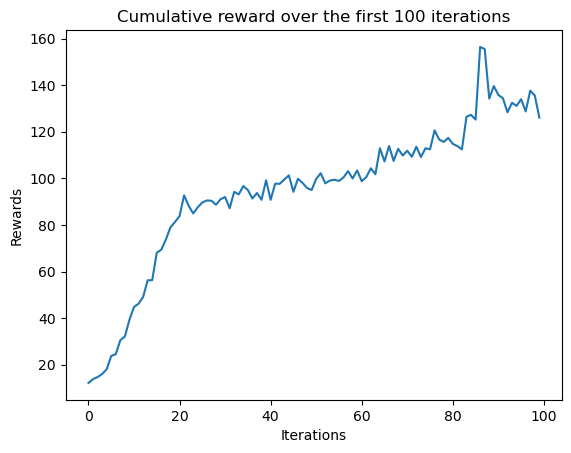

In [21]:
Monte_Carlo_Agent = Monte_Carlo(env, discount_factor = 0.99, epsilon = 0.9, epsilon_decay = 0.9995)
reward = Monte_Carlo_Agent.train_n_iterations(100)

fig, ax = plt.subplots() 
plt.plot(reward)
plt.title("Cumulative reward over the first 100 iterations")
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.show()

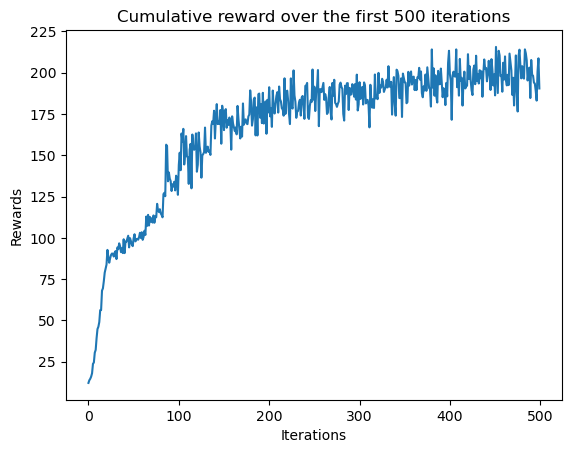

In [22]:
reward.extend(Monte_Carlo_Agent.train_n_iterations(400))

fig, ax = plt.subplots() 
plt.plot(reward)
plt.title("Cumulative reward over the first 500 iterations")
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.show()

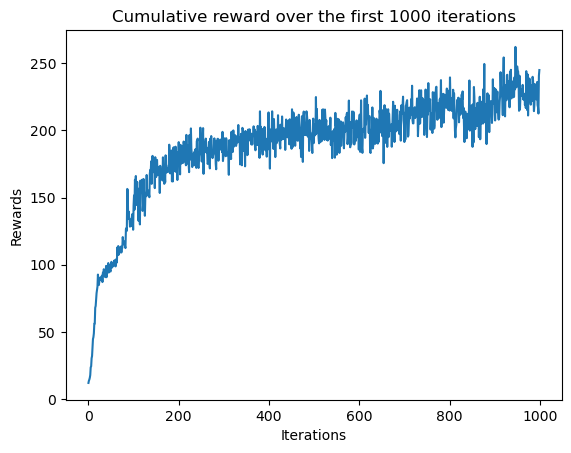

In [23]:
reward.extend(Monte_Carlo_Agent.train_n_iterations(500))

fig, ax = plt.subplots() 
plt.plot(reward)
plt.title("Cumulative reward over the first 1000 iterations")
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.show()

In [24]:
observation, _ = env.reset()
action = Monte_Carlo_Agent.optimal_action(observation)

print("Observation:", observation)
print("Chosen action:", action)

Observation: [0.0416746  0.03043391 0.01525603 0.03122342]
Chosen action: 1


### Task 2: Demonstrate the effectiveness of the RL agent

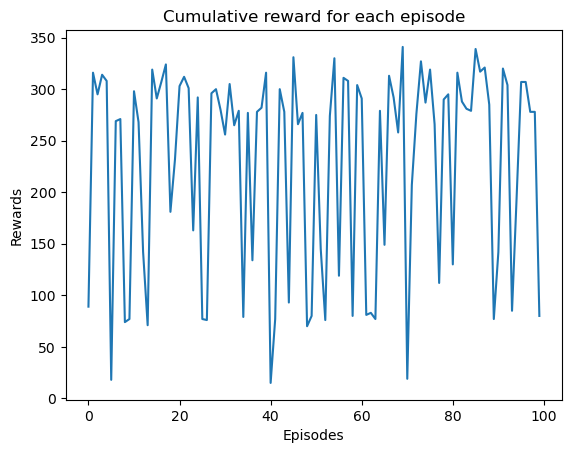

Average cumulative reward: 228.34
Is my agent good enough? True


In [25]:
episode_results = Monte_Carlo_Agent.test(100)

plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()

print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

### Task 3: Render one episode played by the agent